In [2]:
!pip install emoji wordcloud textblob nltk seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import re
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

True

In [5]:

tokenizer = TweetTokenizer()

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'https?://\S+', 'link', text)  # Replace URLs with 'link'
    text = re.sub(r'@\w+', 'mention', text)  # Replace @mentions
    text = re.sub(r'\b\d+(\.\d+)?[kKmM]?\b', 'number', text)  # Replace numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Clean extra spaces
    return text

def count_emojis(text):
    return sum(1 for char in text if char in emoji.EMOJI_DATA)

def count_hashtags(text):
    return len(re.findall(r'#\w+', text))

def has_link(text):
    return 'link' in text

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

def classify_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

def get_top_common_words(tokens_list, top_n=20):
    all_words = []
    for tokens in tokens_list:
        all_words.extend(tokens)
    common_words = [word for word, freq in Counter(all_words).most_common(top_n)]
    return set(common_words)

def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def plot_histogram(data, column, title, xlabel):
    sns.histplot(data=data, x=column, hue='label', element='step', stat='density', common_norm=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.show()

def plot_top_hashtags(hashtag_counter, title, top_n=10):
    hashtags, counts = zip(*hashtag_counter.most_common(top_n))
    hashtag_df = pd.DataFrame({'Hashtag': hashtags, 'Count': counts})

    plt.figure(figsize=(8,6))
    sns.barplot(data=hashtag_df, x='Count', y='Hashtag')
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('Hashtag')
    plt.show()

def plot_sentiment_distribution(data):
    plt.figure(figsize=(8,6))
    sns.countplot(data=data, x='sentiment_label', hue='label', order=['positive', 'negative', 'neutral'])
    plt.title('Sentiment Label Distribution by Tweet Type')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

def count_sentiment_by_label(df):
    counts = df.groupby(['label', 'sentiment_label']).size().reset_index(name='count')
    print("\n--- Number of Tweets by Label and Sentiment ---")
    print(counts)
    return counts


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df = pd.read_csv("drive/MyDrive/COMM 188C/COMM188C Group Project/data/full.csv")
df['raw_tweet'] = df['tweet']
df['tweet'] = df['tweet'].apply(preprocess_text)
df['tokens'] = df['tweet'].apply(tokenizer.tokenize)
standard_stopwords = set(stopwords.words('english'))
common_words = get_top_common_words(df['tokens'], top_n=20)
print(f"Top common words (before adding stopwords): {common_words}")

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/COMM 188C/COMM188C Group Project/data/full.csv'

In [ ]:
def run_eda(df):

    df['tweet_length'] = df['tokens'].apply(len)
    df['emoji_count'] = df['tweet'].apply(count_emojis)
    df['hashtag_count'] = df['raw_tweet'].apply(count_hashtags)
    df['has_link'] = df['tweet'].apply(has_link)
    df['sentiment'] = df['tweet'].apply(get_sentiment)
    df['sentiment_label'] = df['sentiment'].apply(classify_sentiment)

    real_tokens = [word for tokens in df[df['label'] == 'real']['tokens_clean'] for word in tokens]
    fake_tokens = [word for tokens in df[df['label'] == 'fake']['tokens_clean'] for word in tokens]

    real_tokens = [word for word in real_tokens if not word.startswith('#')]
    fake_tokens = [word for word in fake_tokens if not word.startswith('#')]
    plot_wordcloud(' '.join(real_tokens), 'Real news')
    plot_wordcloud(' '.join(fake_tokens), 'Fake news')

    plot_histogram(df, 'tweet_length', 'Tweet Length Distribution', 'Number of Words')
    plot_histogram(df, 'emoji_count', 'Emoji Count Distribution', 'Number of Emojis')
    plot_histogram(df, 'hashtag_count', 'Hashtag Count Distribution', 'Number of Hashtags')
    plot_histogram(df, 'sentiment', 'Sentiment Distribution', 'Sentiment Polarity')

    real_hashtags = Counter([tag for tweet in df[df['label']=='real']['raw_tweet'] for tag in re.findall(r'#\w+', tweet)])
    fake_hashtags = Counter([tag for tweet in df[df['label']=='fake']['raw_tweet'] for tag in re.findall(r'#\w+', tweet)])
    plot_top_hashtags(real_hashtags, 'Top Hashtags - Real Tweets', top_n=15)
    plot_top_hashtags(fake_hashtags, 'Top Hashtags - Fake Tweets', top_n=15)

    real_words = Counter(real_tokens)
    fake_words = Counter(fake_tokens)

    print("\n--- Top Words in Real Tweets (after removing common words) ---")
    print([word for word in real_words.most_common(20)])

    print("\n--- Top Words in Fake Tweets (after removing common words) ---")
    print([word for word in fake_words.most_common(20)])

    plot_sentiment_distribution(df)

    sentiment_counts = count_sentiment_by_label(df)

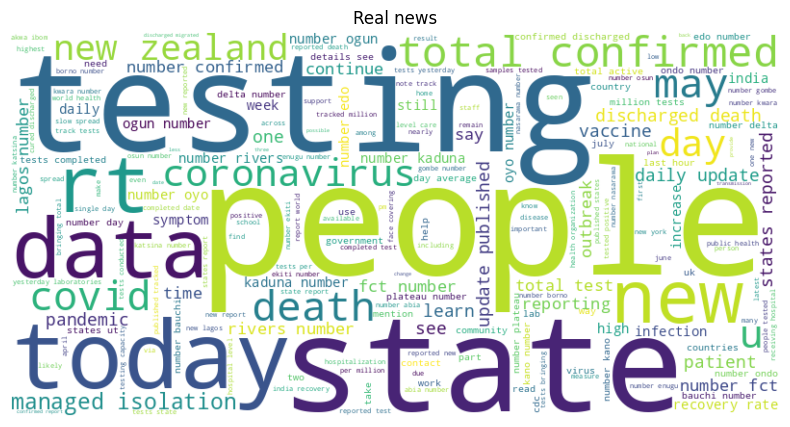

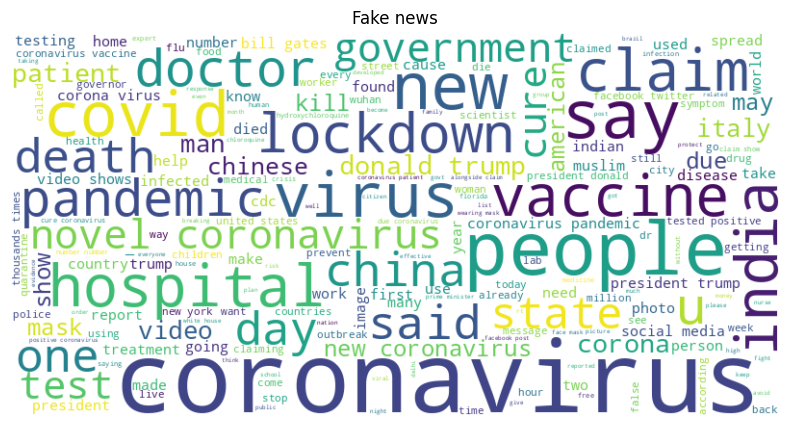

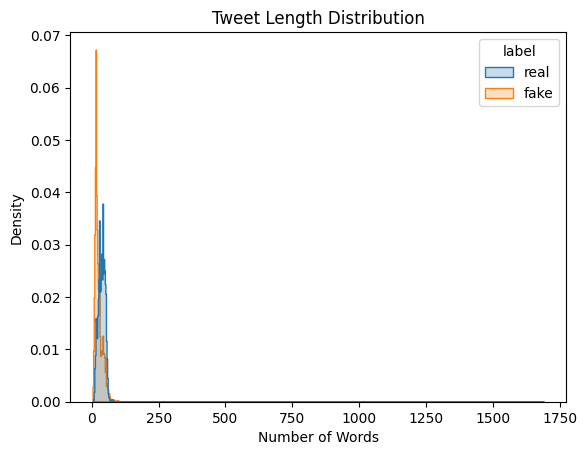

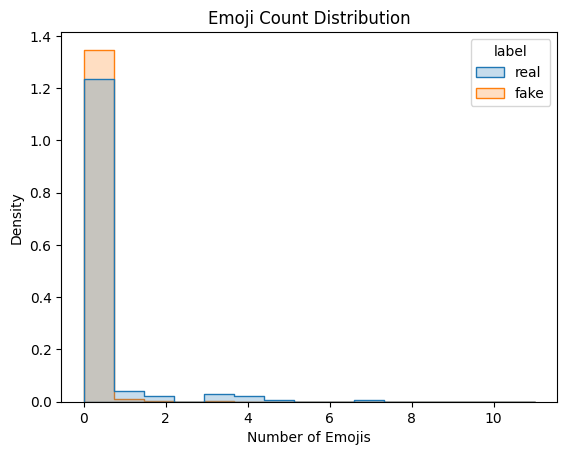

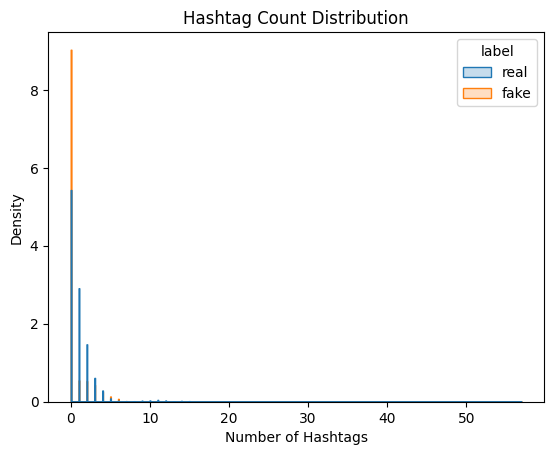

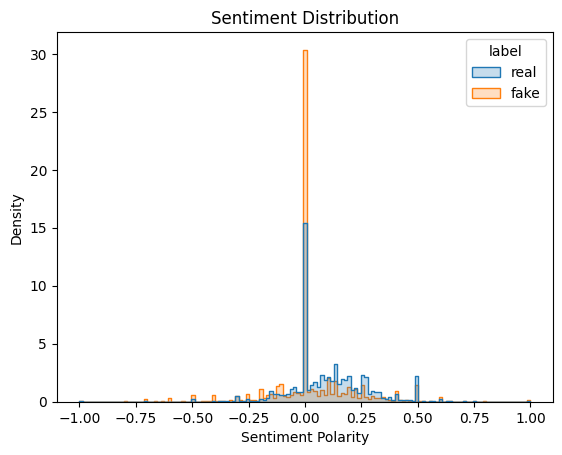

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


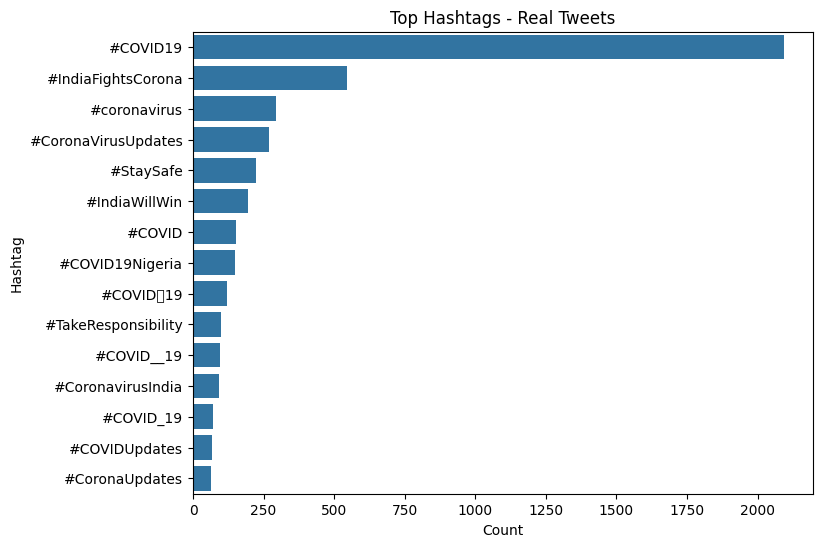

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


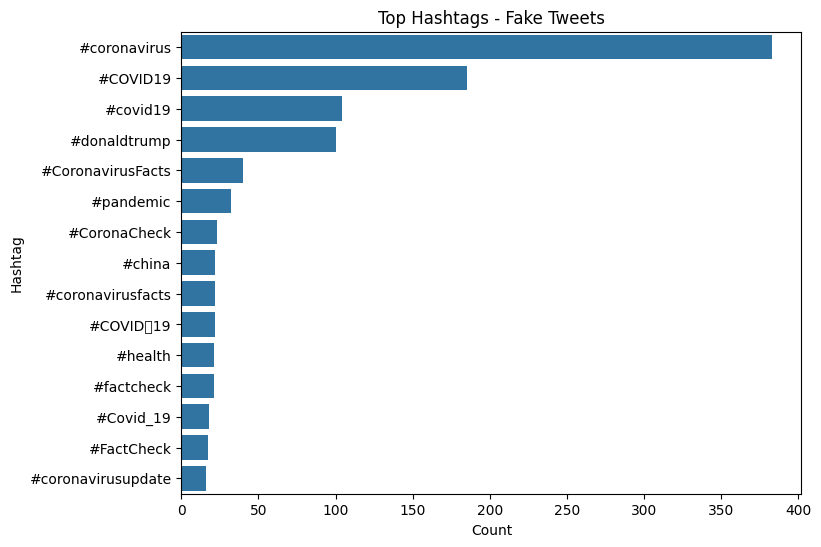


--- Top Words in Real Tweets (after removing common words) ---
[('new', 1452), ('tests', 1101), ('-', 956), ('%', 899), ('deaths', 885), ('states', 842), ('total', 840), ('’', 795), (')', 793), ('(', 778), ('people', 775), ('reported', 735), ('&', 721), ('confirmed', 718), ('testing', 691), ('today', 613), ('/', 546), ('report', 487), ('health', 477), ('state', 456)]

--- Top Words in Fake Tweets (after removing common words) ---
[('coronavirus', 1749), (',', 1692), ('"', 956), ('’', 600), ('people', 502), ('!', 492), ('virus', 395), ('trump', 383), ('new', 365), ('vaccine', 345), (')', 339), ('(', 339), ('covid', 333), ('�', 331), ('pandemic', 324), ('says', 322), ('india', 320), ('video', 313), ('”', 285), ('“', 273)]


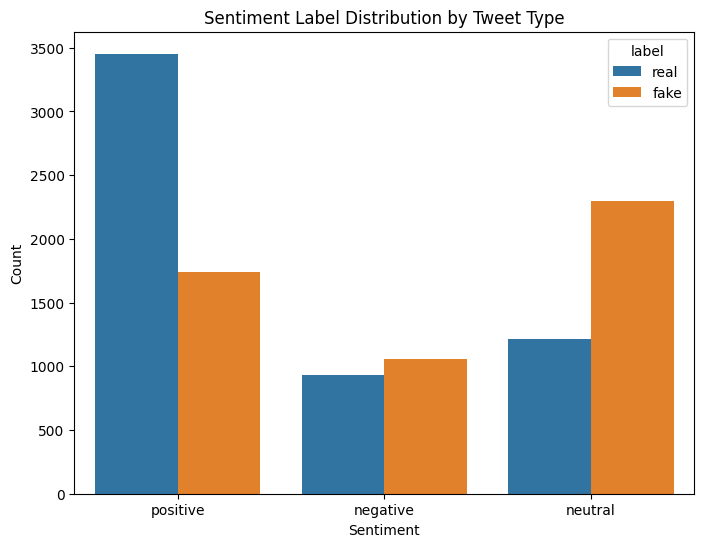


--- Number of Tweets by Label and Sentiment ---
  label sentiment_label  count
0  fake        negative   1056
1  fake         neutral   2301
2  fake        positive   1743
3  real        negative    931
4  real         neutral   1216
5  real        positive   3453
Saved processed data to /content/processed_tweets.csv


In [ ]:
common_words = common_words.union(standard_stopwords)
df['tokens_clean'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word.lower() not in common_words])
run_eda(df)
save_cols = ['tweet', 'tokens', 'tokens_clean', 'label', 'tweet_length', 'emoji_count', 'hashtag_count', 'has_link', 'sentiment', 'sentiment_label']
df[save_cols].to_csv('/content/processed_tweets.csv', index=False)
print("Saved processed data to /content/processed_tweets.csv")

In [ ]:
# building random forest model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

df['clean_text'] = df['tokens_clean'].apply(lambda tokens: ' '.join(tokens))

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean_text'])

y = df['label'].map({'real': 1, 'fake': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9205607476635514

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      1020
           1       0.94      0.91      0.92      1120

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140



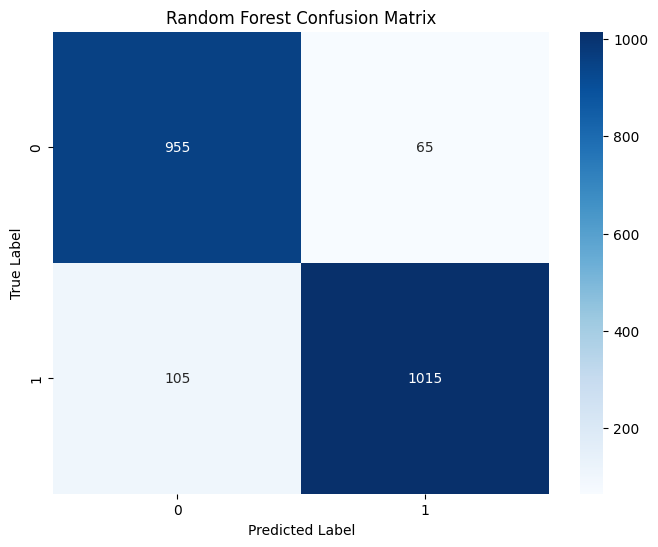

Confusion Matrix:
 [[ 955   65]
 [ 105 1015]]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

y_pred = rf.predict(X_test)

cm_rf = confusion_matrix(y_test, y_pred, labels=rf.classes_)
labels = rf.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Confusion Matrix:\n", cm_rf)

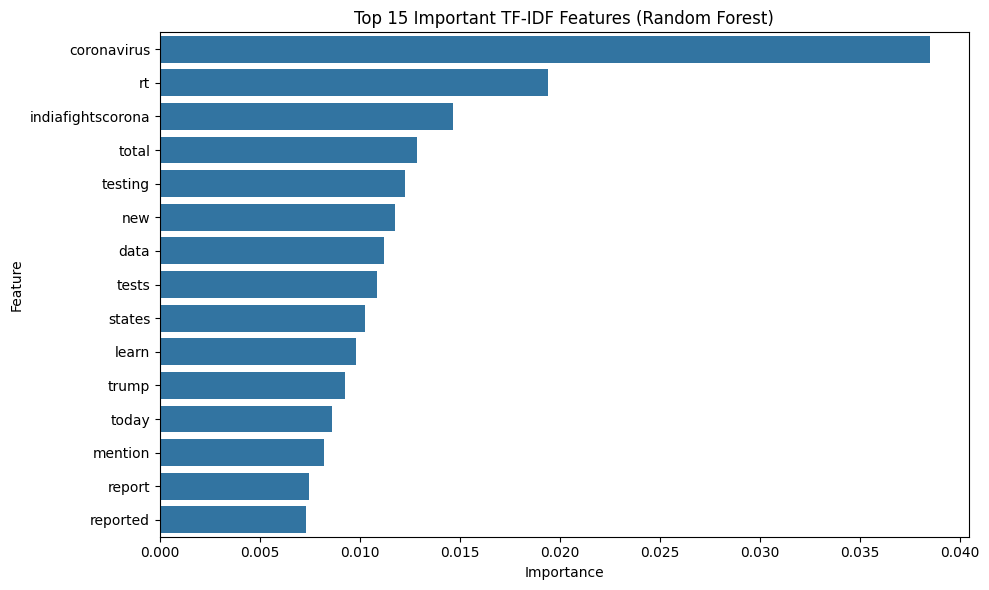

In [ ]:
# feature importance
model = rf

importances = model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:15], y=np.array(feature_names)[indices][:15])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Important TF-IDF Features (Random Forest)')
plt.tight_layout()
plt.show()